In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy
import cmocean

import seaborn as sns

sns.set_context("talk")

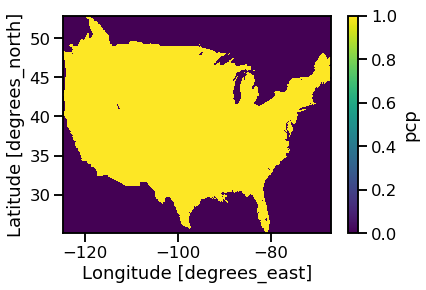

In [30]:
mask = xr.open_dataset('/glade/u/home/jhamman/workdir/stats/mean_bcsd_hist_ACCESS1-0.nc')['pcp'].notnull().squeeze().drop('gcm')
mask.plot()

In [31]:
def load_stat(stat, gcm, method):
    fname = f'/glade/u/home/jhamman/workdir/stats/{stat}_{method}_hist_{gcm}.nc'
    da_hist = xr.open_dataset(fname)['pcp']
    
    fname = f'/glade/u/home/jhamman/workdir/stats/{stat}_{method}_rcp85_{gcm}.nc'
    da_rcp8 = xr.open_dataset(fname)['pcp']
    
    return (da_rcp8 - da_hist).squeeze()
    

In [42]:
# gcms = ['ACCESS1-0', 'MIROC5', 'MRI-CGCM3', 'NorESM1-M', ]
# gcms = ['ACCESS1-0', 'CanESM2','MIROC5', 'MRI-CGCM3','bcc-csm1-1'] #doesn't work cause not stashed

gcms = ['ACCESS1-0','CanESM2','CCSM4','CNRM-CM5','MIROC5','MRI-CGCM3','NorESM1-M']  #ones that have extreme stats

# 'CNRM-CM5', 'CanESM2' # broken in GARD
# methods = ['bcsd', 'loca', 'icar', 'gard']
methods = ['bcsd', 'loca']
gard_methods = ['AR_uvq', 'AR_puv', 'PT_p']


In [43]:
def get_data(stat, gcms=gcms, methods=methods, gard_methods=gard_methods):
    ds_dict = {}

    for scen in ['hist', 'rcp85']:
        concat_methods = []
        ds_list = []
        for method in methods:
            fname = '/glade/u/home/jhamman/workdir/stats/{stat}_{method}_{scen}_{gcm}.nc'
            files = [fname.format(stat=stat, method=method, scen=scen, gcm=gcm) for gcm in gcms]
            ds = xr.open_mfdataset(files, concat_dim=xr.Variable('gcm', gcms))
            # special handling for gard
            if 'config' in ds.dims:
                for gm in gard_methods:
                    if 'lat' in ds:
                        ds = ds.drop(['lat', 'lon']).rename({'y': 'lat', 'x': 'lon'})
                    concat_methods.append(gm)
                    ds_list.append(ds.sel(config=gm).drop('config'))
            else:
                concat_methods.append(method)
                ds_list.append(ds)
        ds_dict[scen] = xr.concat(ds_list, dim=xr.Variable('dsmethod', concat_methods)).where(mask)
    return ds_dict


def calc_change(future, hist, pct=False):
    if pct:
        return (future - hist) / hist * 100
    else:
        return (future - hist)

In [45]:
import cartopy.feature as cfeature

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

extent = (-125, -100, 25, 53)
projection = ccrs.LambertAzimuthalEqualArea(
        (extent[0] + extent[1]) / 2,
        (extent[2] + extent[3]) / 2)

In [46]:

def plot_grid(da, title=None, cbar_label=None, **kwargs):
    
    
    p = da.plot(
        col='dsmethod', row='gcm', robust=True,
        transform=ccrs.PlateCarree(),
        subplot_kws={'projection': projection},
        **kwargs)
    if cbar_label:
        p.cbar.set_label(cbar_label)
    if title:
        p.fig.suptitle(title, y=1.02)
    
    draw_features(p)
    cleanup_text(p)

    return p


def cleanup_text(p):
    for ax in p.axes.flat:
        text = ax.title.get_text()

        if 'gcm' in text:
            text = text.replace('gcm = ', '')
        if 'dsmethod' in text:
            text = text.replace('dsmethod = ', '')
            if 'PT_p' in text:
                text = 'WRF50'
            if text in gard_methods:
                text = 'GARD ' + text
            text = text.upper()
        
        ax.set_title(text)


def draw_features(p):
    for ax in p.axes.flat:
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS)
        ax.add_feature(states_provinces, lw=0.5, edgecolor='gray')
        ax.set_extent(extent, ccrs.PlateCarree())

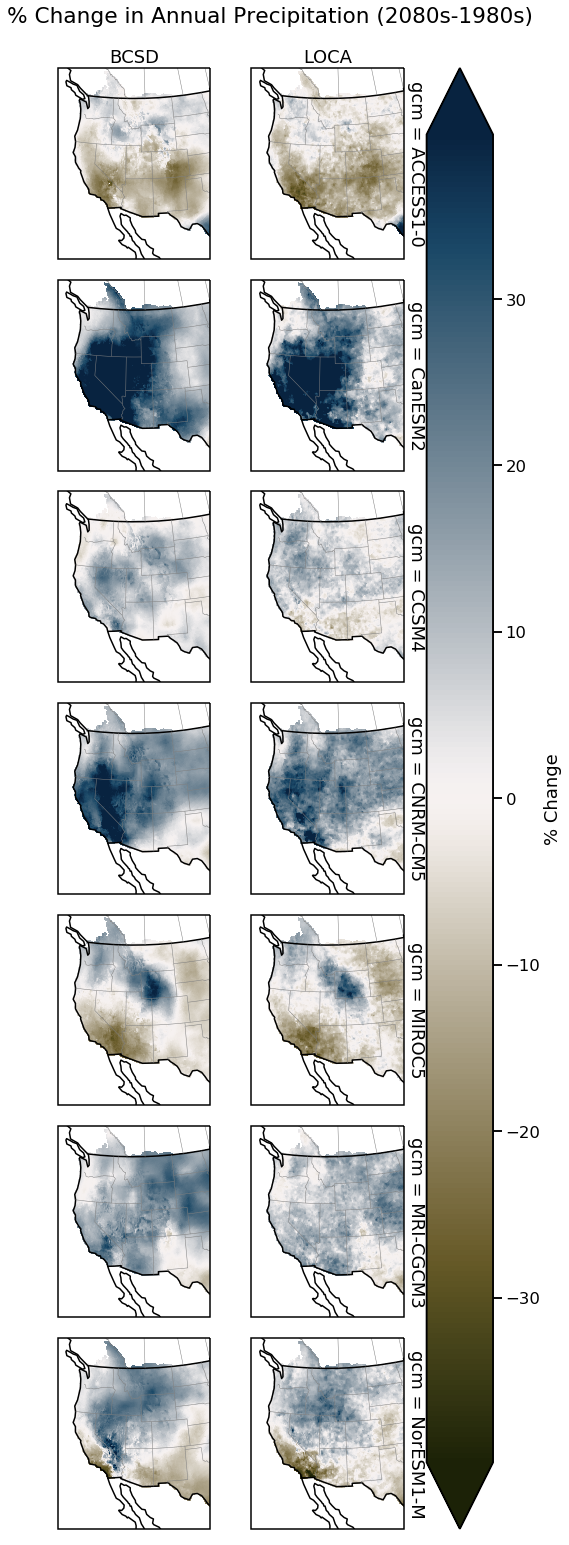

In [47]:
ds_dict = get_data('mean')
da = calc_change(ds_dict['rcp85']['pcp'], ds_dict['hist']['pcp'], pct=True)
p = plot_grid(da, cmap=cmocean.cm.diff_r, title='% Change in Annual Precipitation (2080s-1980s)', cbar_label='% Change')

/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/dask/array/reductions.py:386: RuntimeWarning: divide by zero encountered in true_divide
  u = total / n
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/dask/array/reductions.py:386: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5,1.11,'Standard Deviation of % Change in Annual Precipitation (2080s-1980s)')

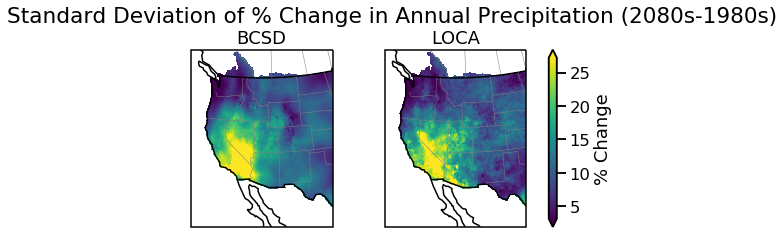

In [48]:
p = da.std(dim='gcm').plot(
    col='dsmethod',
    robust=True,
    transform=ccrs.PlateCarree(),
    subplot_kws={'projection': projection})
draw_features(p)
cleanup_text(p)

p.cbar.set_label('% Change')
p.fig.suptitle('Standard Deviation of % Change in Annual Precipitation (2080s-1980s)', y=1.11)

Text(0.5,1.04,'Standard Deviation of % Change in Annual Precipitation (2080s-1980s)')

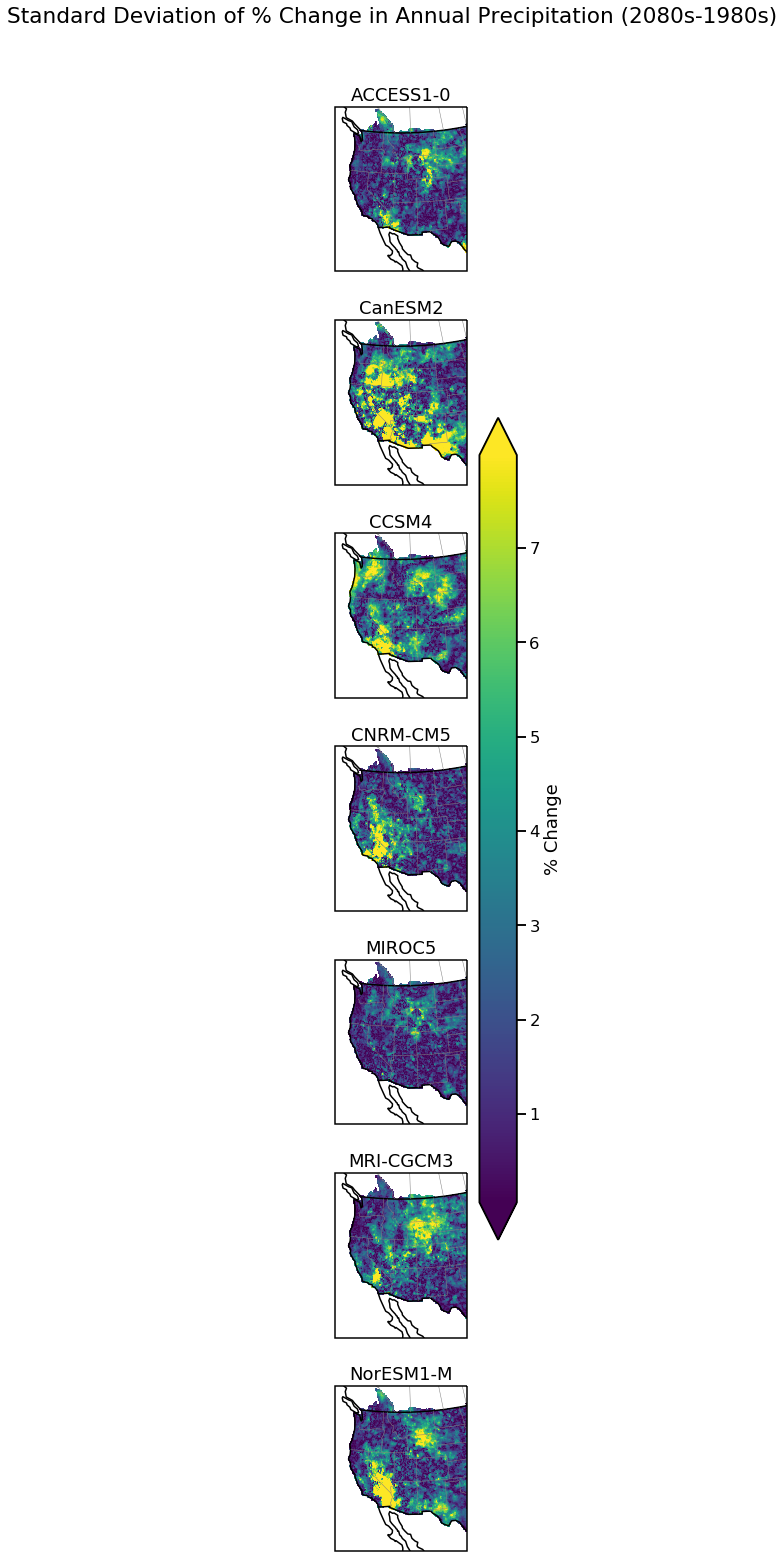

In [49]:
p = da.std(dim='dsmethod').plot(
    row='gcm',
    robust=True,
    transform=ccrs.PlateCarree(),
    subplot_kws={'projection': projection})

draw_features(p)
cleanup_text(p)

p.cbar.set_label('% Change')
p.fig.suptitle('Standard Deviation of % Change in Annual Precipitation (2080s-1980s)', y=1.04)

1. mean across all gcms
1. mean across all ds methods
1. std dev across all gcms/dsmethds
1. font sizes
1. histogram type plot

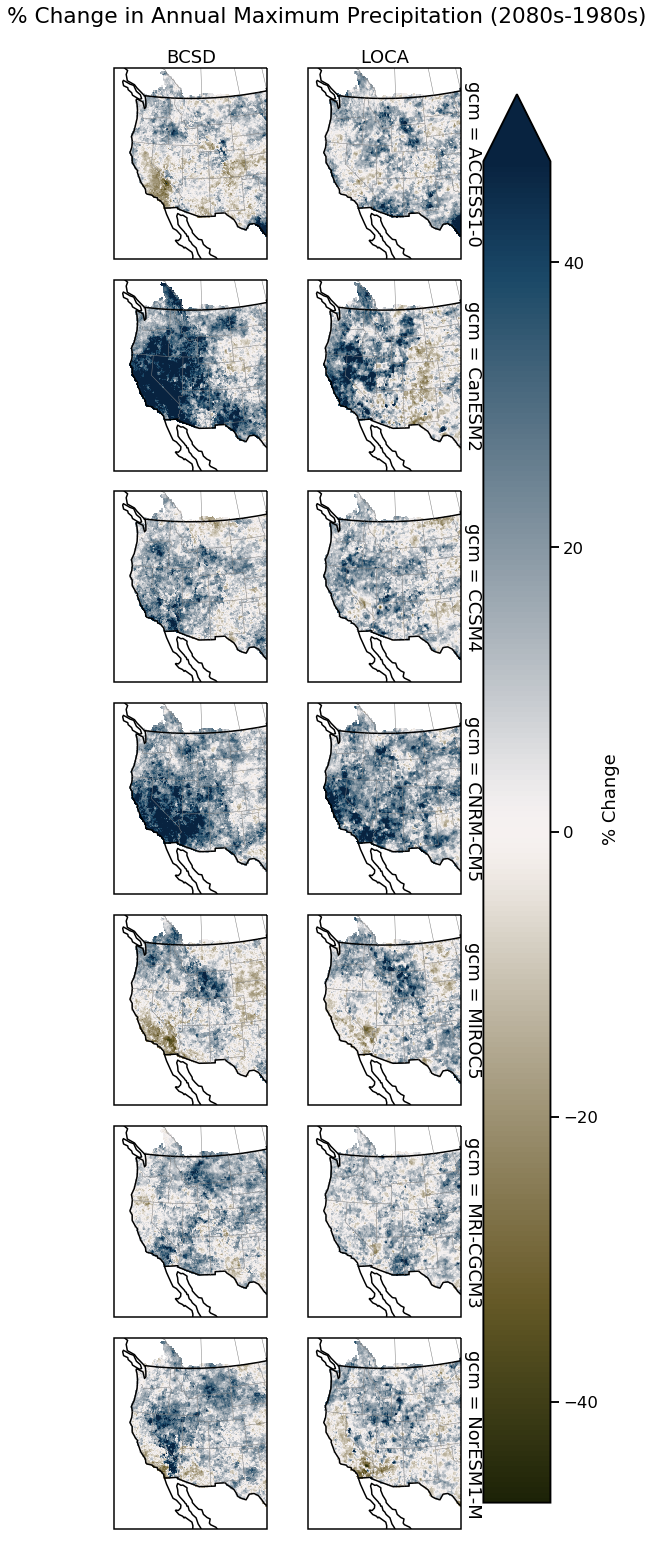

In [54]:
ds_dict = get_data('annmax')
da = calc_change(ds_dict['rcp85']['pcp'], ds_dict['hist']['pcp'], pct=True)
p = plot_grid(da, cmap=cmocean.cm.diff_r, title='% Change in Annual Maximum Precipitation (2080s-1980s)', cbar_label='% Change')

Text(0.5,1.11,'Standard Deviation of % Change in Annual Maximum Precipitation (2080s-1980s)')

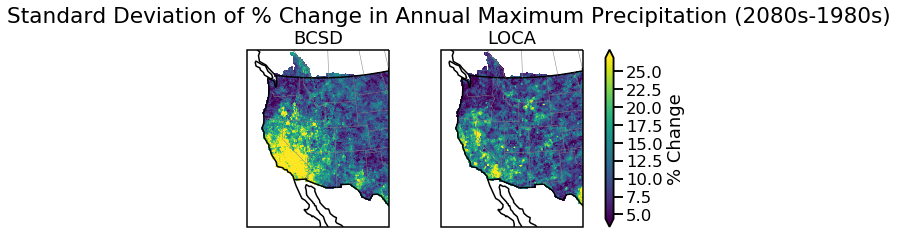

In [53]:
p = da.std(dim='gcm').plot(
    col='dsmethod',
    robust=True,
    transform=ccrs.PlateCarree(),
    subplot_kws={'projection': projection})

draw_features(p)
cleanup_text(p)
p.cbar.set_label('% Change')
p.fig.suptitle('Standard Deviation of % Change in Annual Maximum Precipitation (2080s-1980s)', y=1.11)

Text(0.5,1.04,'Standard Deviation of % Change in Annual Maximum Precipitation (2080s-1980s)')

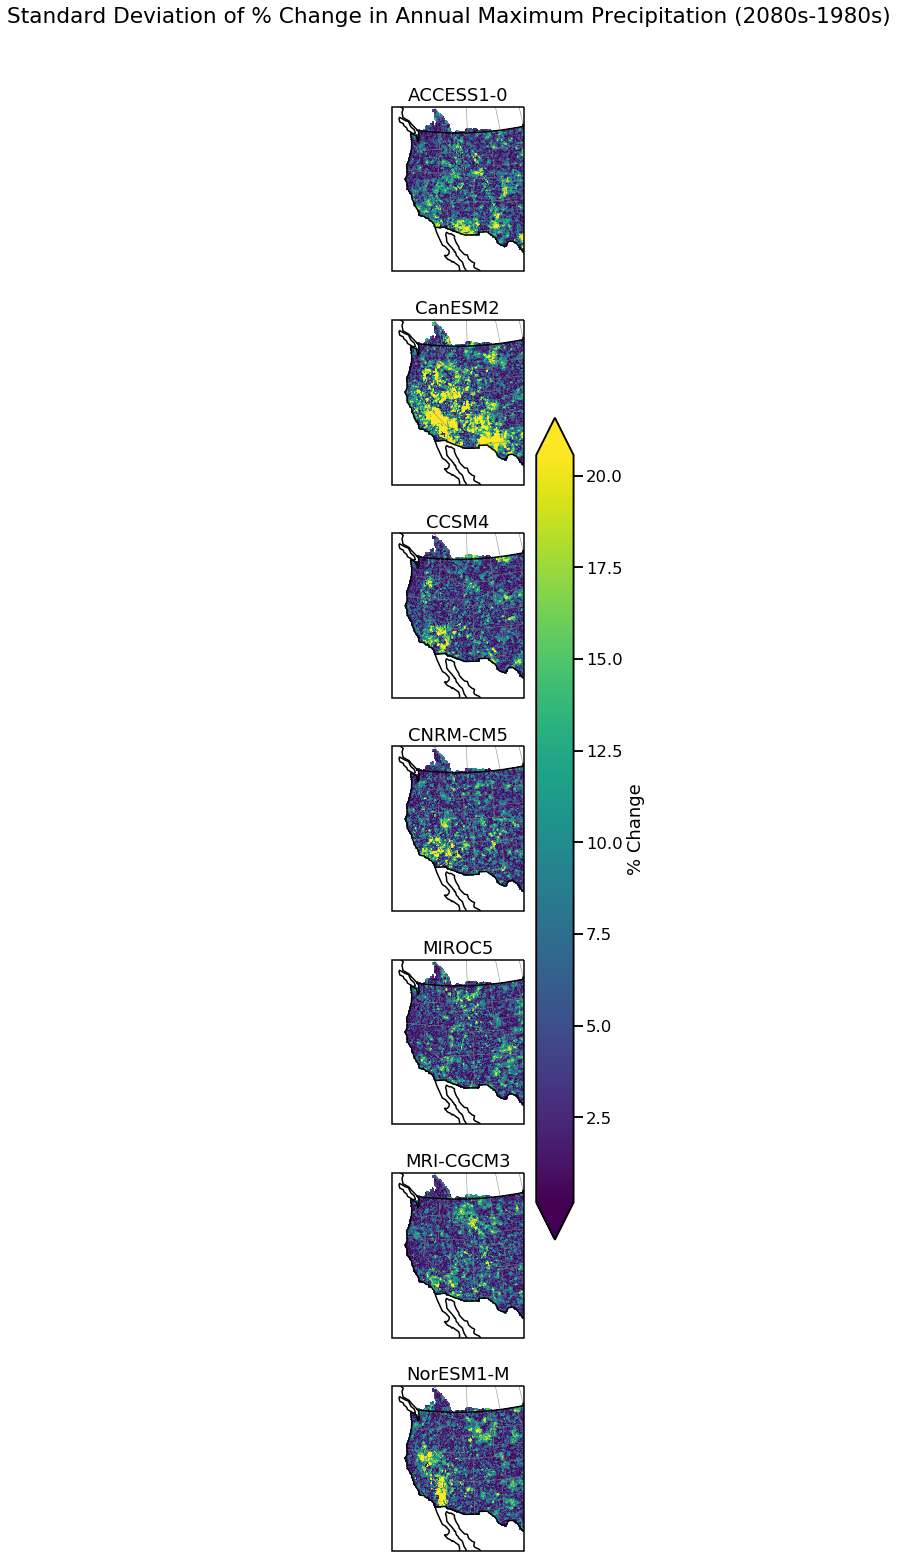

In [55]:
p = da.std(dim='dsmethod').plot(
    row='gcm',
    robust=True,
    transform=ccrs.PlateCarree(),
    subplot_kws={'projection': projection})

draw_features(p)
cleanup_text(p)

p.cbar.set_label('% Change')
p.fig.suptitle('Standard Deviation of % Change in Annual Maximum Precipitation (2080s-1980s)', y=1.04)

In [56]:
import regionmask

In [57]:
states = regionmask.defined_regions.natural_earth.us_states_50

In [58]:
state_mask = states.mask(mask, wrap_lon=180)

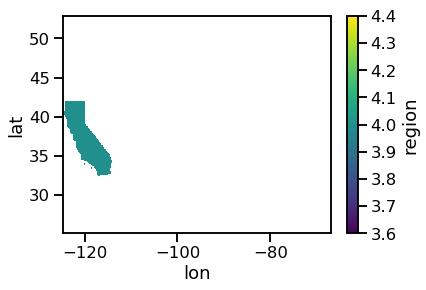

In [59]:
ca_mask = state_mask.where(state_mask==4)  # 4 == CA
ca_mask.plot()

In [24]:
df = da.where(ca_mask).mean(('lat', 'lon'))

In [60]:
ylabels = df.dsmethod.values
ylabels

array(['bcsd', 'loca', 'icar', 'AR_uvq', 'AR_puv', 'PT_p'], dtype='<U6')

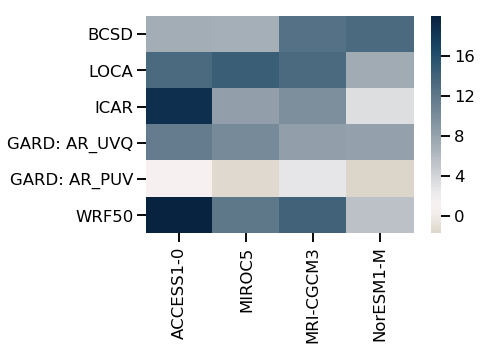

In [61]:
ylabels = ['BCSD', 'LOCA', 'ICAR', 'GARD: AR_UVQ', 'GARD: AR_PUV', 'WRF50']

ax = sns.heatmap(df, xticklabels=df.gcm.values, yticklabels=ylabels, cmap=cmocean.cm.diff_r, center=True)